<a href="https://colab.research.google.com/github/AmirGhnbr/PubMed_200k_RCT/blob/dev_branch/PubMed_200k_RCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trying to replicate [PubMed 200k RCT](https://arxiv.org/pdf/1710.06071.pdf) useing [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf) paper

In [1]:
## Set up GPU
!nvidia-smi

Sun Oct 16 13:36:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Donwload the dataset

### In a phenomenal act of kindness, the authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files on [GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct).

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [6]:
def get_lines(filepath):
  """
  open and return the files
  """
  with open(filepath,"r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:16]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
def preprocess_with_line_numbers(filepath):
  """
  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args: 
  
  filename: a string of the target path
  """
  input_lines = get_lines(filepath)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###") :
      abstract_id = line
      abstract_lines = ""
    elif line.isspace(): # check to see if its new line
      abstract_line_split = abstract_lines.splitlines() 

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number 
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [9]:
%%time
train_samples = preprocess_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 713 ms, sys: 160 ms, total: 873 ms
Wall time: 1.08 s


(180040, 30212, 30135)

In [10]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

## Lets turn ductionaries into dataframe

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(16)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

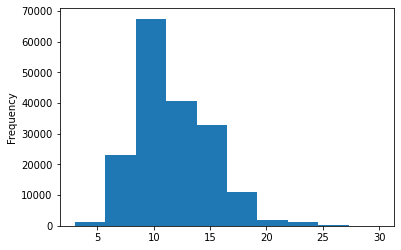

In [13]:
train_df["total_lines"].plot.hist();

looks like majority of abstracts are around 7-15 lenght

## get list of sentences

When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

In [14]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## make labels numerical

In [15]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### label encodes labels

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded, train_labels_encoded.shape

(array([3, 2, 2, ..., 4, 1, 1]), (180040,))

In [17]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Baseline model

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("TfidfVectorizer", TfidfVectorizer()),
    ("gaussianNB", MultinomialNB())
])

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                ('gaussianNB', MultinomialNB())])

In [19]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [20]:
baseline_preds = model_0.predict(test_sentences)
baseline_preds

array([2, 2, 2, ..., 4, 4, 4])

Evaluate using :

* Accuracy
* Percision
* Recall
* F1-score

In [21]:
# download helper function
!wget https://raw.githubusercontent.com/AmirGhnbr/Big-Food-Vision/main/helper.py

--2022-10-16 13:37:15--  https://raw.githubusercontent.com/AmirGhnbr/Big-Food-Vision/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10568 (10K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  10.32K  --.-KB/s    in 0s      

2022-10-16 13:37:16 (83.5 MB/s) - ‘helper.py’ saved [10568/10568]



In [22]:
from helper import calculate_results
calculate_results(test_labels_encoded,
                  baseline_preds) 

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

## Prepare data for sequence models

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [24]:
sen_length = [len(sentence.split()) for sentence in train_sentences]
sen_length[:10]

[49, 27, 15, 14, 35, 29, 30, 55, 36, 8]

In [25]:
average_sentence_len = np.mean(sen_length)
average_sentence_len

26.338269273494777

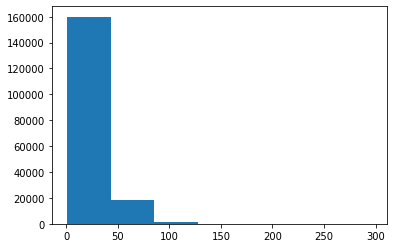

In [26]:
import matplotlib.pyplot as plt
plt.hist(sen_length,bins =7);

In [27]:
output_sec_len = int(np.percentile(sen_length,95))
output_sec_len

55

95 % of data's length are less than 55

## Create Text vectorizer

In [28]:
max_tokens = 68000 ## according to paper

In [29]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length =output_sec_len)
text_vectorizer

In [30]:
text_vectorizer.adapt(train_sentences)

In [31]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
by combining pre - and poststimulation data , interaction models for bis , se , and re demonstrate a consistent influence of `` stimulation '' on the pharmacodynamic relationship between sevoflurane and remifentanil .

Length of text: 34

Vectorized text:
[[   22  2432  1093     3 29172   100   605   476    11  2649  1215     3
   4013  1089     8   905   646     4   465    18     2  3214   639    30
   1818     3  1442     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [32]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


## Create custom  text Embedding

In [33]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero= True,
                               name= "embedding")

In [34]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
by combining pre - and poststimulation data , interaction models for bis , se , and re demonstrate a consistent influence of `` stimulation '' on the pharmacodynamic relationship between sevoflurane and remifentanil .

Sentence after vectorization (before embedding):
[[   22  2432  1093     3 29172   100   605   476    11  2649  1215     3
   4013  1089     8   905   646     4   465    18     2  3214   639    30
   1818     3  1442     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.00081087 -0.03844651 -0.00237836 ...  0.03261114  0.00194231
   -0.0043684 ]
  [ 0.04752323  0.02877451 -0.01573665 ...  0.04116945  0.03468298
    0.03477881]
  [ 0.00540786 -0.02299827  0.00749319 ...  0.03392157 -0.00396501
   -0.02897737]
  ...
  [ 0.02483617 -0.01851436 -0.03991265 ...  0.02203302 -0.00419245
    0.0040

## Create datasets

In [35]:
train_dataset= tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [36]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [37]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vector = text_vectorizer(inputs)
token_embeding = token_embed(text_vector)
x = layers.Conv1D(64, 5, padding="same", activation="relu")(token_embeding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.models.Model(inputs, outputs)
model_1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [38]:
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [39]:
model_1.fit(train_dataset,
            steps_per_epoch= int(0.1*len(train_dataset)),
            epochs=5, 
            validation_data= val_dataset,
            validation_steps = int(0.1*len(val_dataset))
            )

Epoch 1/5
562/562 [==============================] - 15s 9ms/step - loss: 0.9212 - accuracy: 0.6347 - val_loss: 0.6882 - val_accuracy: 0.7354
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6613 - accuracy: 0.7542 - val_loss: 0.6347 - val_accuracy: 0.7676
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6201 - accuracy: 0.7743 - val_loss: 0.5971 - val_accuracy: 0.7842
Epoch 4/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5903 - accuracy: 0.7898 - val_loss: 0.5804 - val_accuracy: 0.7852
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5919 - accuracy: 0.7906 - val_loss: 0.5616 - val_accuracy: 0.7985


In [41]:
model_1.evaluate(test_dataset)

942/942 [==============================] - 3s 3ms/step - loss: 0.5745 - accuracy: 0.7948


[0.5744878649711609, 0.7947900891304016]

In [46]:
model_1_prob_preds = model_1.predict(test_dataset)
model_1_prob_preds

942/942 [==============================] - 2s 2ms/step


array([[2.2551946e-01, 7.9902023e-02, 5.0411242e-01, 1.1993711e-01,
        7.0528902e-02],
       [5.2099074e-03, 2.3309428e-03, 9.6534991e-01, 4.3792333e-03,
        2.2729978e-02],
       [4.3871236e-04, 1.1272219e-03, 9.6633053e-01, 2.2334632e-04,
        3.1880118e-02],
       ...,
       [6.2868157e-03, 3.8108673e-02, 2.2292398e-02, 2.3377931e-03,
        9.3097430e-01],
       [7.4452739e-03, 3.5410255e-02, 6.2347908e-02, 3.1877633e-03,
        8.9160883e-01],
       [5.5990857e-03, 6.0576797e-01, 4.5814171e-02, 7.4696848e-03,
        3.3534902e-01]], dtype=float32)

In [47]:
model_1_preds = np.argmax(model_1_prob_preds, axis=1)
model_1_preds

array([2, 2, 2, ..., 4, 4, 1])

In [49]:
model_1_result = calculate_results(test_labels_encoded,
                                   model_1_preds)
model_1_result

{'accuracy': 79.47901111664177,
 'precision': 0.7936641074207218,
 'recall': 0.7947901111664177,
 'f1': 0.7916331983435851}

## Model 2: Feature Extractor model with pretrained token embeddings